In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

from time import time

In [2]:
#code from : https://jessesw.com/XG-Boost/

In [3]:
#read data:
train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', 
                        header = None)
test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',
                      skiprows = 1, header = None) # Make sure to skip a row for the test set

In [5]:
train_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
test_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [7]:
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']

In [8]:
train_set.columns = col_labels
test_set.columns = col_labels

In [9]:
#unknowns are included and have been labeled with a question mark (" ?")
#notice the space before the Q mark
#we will drop rows with this and take only the remaining records

In [12]:
train_setnomissing = train_set.replace(" ?", np.nan).dropna()
test_setnomissing = test_set.replace(" ?", np.nan).dropna()

In [13]:
len(train_setnomissing), len(test_setnomissing)

(30162, 15060)

In [14]:
#in test, there is a dot in the value of the target field
#i.e, instead of "<=50K" (as in train), test has it as "<=50K."
#replace that as well

In [15]:
train_setnomissing.wage_class.unique()

array([' <=50K', ' >50K'], dtype=object)

In [16]:
test_setnomissing.wage_class.unique()

array([' <=50K.', ' >50K.'], dtype=object)

In [17]:
test_setnomissing['wage_class'] = test_setnomissing.wage_class.replace({' <=50K.': ' <=50K', ' >50K.':' >50K'})

In [18]:
test_setnomissing.wage_class.unique()

array([' <=50K', ' >50K'], dtype=object)

In [19]:
#next step is to do One Hot Encoding on categoricals
#we concatenate the train and test to do this at one go

In [20]:
ntrain = len(train_setnomissing)
ntest = len(test_setnomissing)
concat_df = pd.concat([train_setnomissing, test_setnomissing], axis = 0)

In [21]:
concat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 16280
Data columns (total 15 columns):
age               45222 non-null int64
workclass         45222 non-null object
fnlwgt            45222 non-null int64
education         45222 non-null object
education_num     45222 non-null int64
marital_status    45222 non-null object
occupation        45222 non-null object
relationship      45222 non-null object
race              45222 non-null object
sex               45222 non-null object
capital_gain      45222 non-null int64
capital_loss      45222 non-null int64
hours_per_week    45222 non-null int64
native_country    45222 non-null object
wage_class        45222 non-null object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB


In [23]:
for feature in concat_df.columns:
    if concat_df[feature].dtype == 'object':
        concat_df[feature] = pd.Categorical(concat_df[feature]).codes

In [24]:
concat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 16280
Data columns (total 15 columns):
age               45222 non-null int64
workclass         45222 non-null int8
fnlwgt            45222 non-null int64
education         45222 non-null int8
education_num     45222 non-null int64
marital_status    45222 non-null int8
occupation        45222 non-null int8
relationship      45222 non-null int8
race              45222 non-null int8
sex               45222 non-null int8
capital_gain      45222 non-null int64
capital_loss      45222 non-null int64
hours_per_week    45222 non-null int64
native_country    45222 non-null int8
wage_class        45222 non-null int8
dtypes: int64(6), int8(9)
memory usage: 2.8 MB


In [25]:
#take a look at the change in info after the encoding
#all are ints
#also the memory usage has reduced

In [28]:
train_setnomissing.shape[0], ntrain

(30162, 30162)

In [29]:
final_train = concat_df[:ntrain]
final_test = concat_df[ntrain:]

In [30]:
len(final_train), len(final_test)

(30162, 15060)

In [31]:
final_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,4,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,2,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,2,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,2,338409,9,13,2,9,5,2,0,0,0,40,4,0


In [32]:
#get the target variable from the dataset
y_train = final_train.pop('wage_class')
y_test = final_test.pop('wage_class')

In [34]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: wage_class, dtype: int8

In [35]:
final_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38
1,50,4,83311,9,13,2,3,0,4,1,0,0,13,38
2,38,2,215646,11,9,0,5,1,4,1,0,0,40,38
3,53,2,234721,1,7,2,5,0,2,1,0,0,40,38
4,28,2,338409,9,13,2,9,5,2,0,0,0,40,4


In [36]:
#notice that in the final train in above, the wage_class field is not present
#this is because we have 'pop'ed it out as the y train

In [37]:
from sklearn.grid_search import GridSearchCV

In [38]:
#now we move on to creating and tuning the params for XGB

In [39]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}


ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8,
              'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}


optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params),
                                cv_params, 
                                scoring = 'accuracy',
                                cv = 5,
                                n_jobs = -1) 

# Optimize for accuracy since that is the metric used in the Adult Data Set notation

In [40]:
#fit the data to this model
optimized_GBM.fit(final_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [41]:
#take a look at the results:
optimized_GBM.grid_scores_

[mean: 0.86685, std: 0.00239, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.86659, std: 0.00371, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.86725, std: 0.00317, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: 0.86178, std: 0.00317, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: 0.85953, std: 0.00251, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: 0.86158, std: 0.00239, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: 0.85611, std: 0.00330, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: 0.85525, std: 0.00323, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: 0.85714, std: 0.00320, params: {'max_depth': 7, 'min_child_weight': 5}]

In [42]:
#best results occur at max_depth:3 and min child weight : 1

In [43]:
from time import time

In [44]:
#let's keep those values and try varying the other parameters
start = time()

cv_params2 = {'learning_rate': [0.1, 0.01], 'subsample': [0.7,0.8,0.9]}

ind_params2 = {'n_estimators': 1000, 'seed':0, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 1}


optimized_GBM2 = GridSearchCV(xgb.XGBClassifier(**ind_params2), 
                            cv_params2, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1)

optimized_GBM2.fit(final_train, y_train)

end = time()

print ((start - end)/60.0)


-5.86606899897


In [45]:
optimized_GBM2.grid_scores_

[mean: 0.86622, std: 0.00271, params: {'subsample': 0.7, 'learning_rate': 0.1},
 mean: 0.86685, std: 0.00239, params: {'subsample': 0.8, 'learning_rate': 0.1},
 mean: 0.86771, std: 0.00349, params: {'subsample': 0.9, 'learning_rate': 0.1},
 mean: 0.85999, std: 0.00307, params: {'subsample': 0.7, 'learning_rate': 0.01},
 mean: 0.86032, std: 0.00272, params: {'subsample': 0.8, 'learning_rate': 0.01},
 mean: 0.86002, std: 0.00282, params: {'subsample': 0.9, 'learning_rate': 0.01}]

In [47]:
#highest score for 'subsample': 0.8, 'learning_rate': 0.1
#from the previous CV other parameters: 'max_depth': 3, 'min_child_weight': 1

In [48]:
xgdmat = xgb.DMatrix(final_train, y_train) # Create our DMatrix to make XGBoost more efficient

In [49]:
#try the native CV of XGB
start = time()
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 
# Grid Search CV optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

end = time()

print ((end - start)/60.0)

1.35806299845


In [50]:
cv_xgb.tail(5)

,test-error-mean,test-error-std,train-error-mean,train-error-std
457,0.130173,0.004067,0.116570,0.001104
458,0.130106,0.004026,0.116578,0.001137
459,0.130040,0.003949,0.116520,0.001080
460,0.130073,0.003919,0.116537,0.001141
461,0.129974,0.003961,0.116512,0.001133


In [56]:
cv_xgb['test-error-mean'][cv_xgb['test-error-mean'] == cv_xgb['test-error-mean'].min()]

461    0.129974
Name: test-error-mean, dtype: float64

In [57]:
final_gb = xgb.train(our_params, xgdmat, num_boost_round = 461)

In [58]:
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1.5)

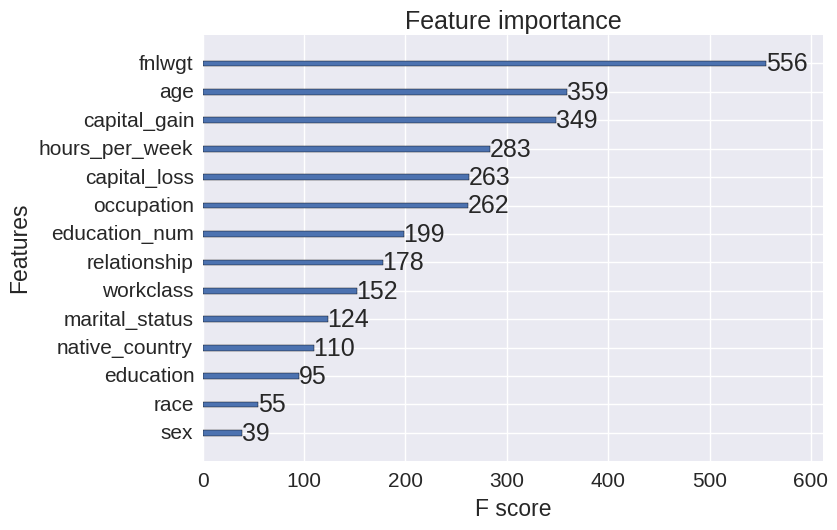

In [59]:
xgb.plot_importance(final_gb)

In [60]:
#apply on test
testdmat = xgb.DMatrix(final_test)

In [61]:
from sklearn.metrics import accuracy_score
y_pred = final_gb.predict(testdmat) # Predict using our testdmat
y_pred

array([ 0.00302884,  0.20670944,  0.30002904, ...,  0.8292715 ,
        0.15922189,  0.78374606], dtype=float32)

In [62]:
type(y_pred)

numpy.ndarray

In [63]:
y_pred_original = y_pred

In [64]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

array([ 0.,  0.,  0., ...,  1.,  0.,  1.], dtype=float32)

In [65]:
accuracy_score(y_pred, y_test), 1-accuracy_score(y_pred, y_test)

(0.86965471447543163, 0.13034528552456837)